# Bezmerizing demo notebook

By [Allison Parrish](https://www.decontextualize.com/)

Bezmerizing is a small, opinionated Python library for dealing with quadratic and cubic Bézier curves and polylines, with the goal of making it easy to do procedural drawing in an arts context. This notebook demonstrates some of the features of the library. (Some features are not included in this notebook—for now you'll need to check the source or docstrings for a more thorough overview of the library's functionality. But I cover most of the important stuff here.)

In [2]:
%load_ext autoreload
%autoreload complete

## Preliminaries

Let's take care of some technical details and utility functions first. Here we're importing the classes we'll need from the Bezmerizing library, along with numpy (always helpful!) and some functions to display SVG files inline in Jupyter Notebook:

In [3]:
from bezmerizing import Polyline, Bezier, QuadraticBezier, PolylineList
import numpy as np
from IPython.display import SVG, display

The functions below fill in a template that creates a valid SVG file, given a list of SVG paths, a list of points, and a list of lines, which is then included in the notebook. This will be helpful for visualizing what we're doing with Bezier curves in the rest of the notebook. (Note that **you don't have to use SVG to draw Bezmerizing objects!** I'm just using SVG in this notebook as a convenience. But you can use Bezmerizing with any drawing library that accepts lists of points to draw polylines, e.g. [vsketch's `polygon` function](https://vsketch.readthedocs.io/en/latest/autoapi/vsketch/index.html#vsketch.Vsketch.polygon) or [py5's `vertices` function](https://py5coding.org/reference/sketch_vertices.html).)

In [4]:
def make_svg(paths=None, points=None, lines=None, path_fill=False):
    if paths is None: paths = []
    if points is None: points = []
    if lines is None: lines = []
    path_colors = ['#000', '#448', '#88a', '#bbf']
    path_tags = []
    # path tags for each path; assign each path a color to help distinguish them
    for i, path in enumerate(paths):
        path_stroke = path_colors[i%len(path_colors)]
        path_fill_c = path_stroke if path_fill else "none"
        path_tags.append(f'<path stroke="{path_stroke}" fill="{path_fill_c}" d="{path}" />')
    point_tags = "\n".join([
        f'<circle cx="{item[0]}" cy="{item[1]}" stroke="none" fill="#d16" r="2" />'
        for item in points])
    line_tags = "\n".join([
        f'<line stroke="#28f" x1="{item[0]}" y1="{item[1]}" x2="{item[2]}" y2="{item[3]}" />'
        for item in lines])
    val = f"""\
<svg
  viewBox="0 0 200 200"
  width="300" height="300"
  xmlns="http://www.w3.org/2000/svg"
  xmlns:xlink="http://www.w3.org/1999/xlink">
{"\n".join(path_tags)}
{point_tags}
{line_tags}
</svg>"""
    return val

def show(paths=None, points=None, lines=None, path_fill=False):
    display(SVG(make_svg(paths, points, lines, path_fill)))

## Bezier objects

A `Bezier` object represents a cubic Bézier curve.

In [5]:
bez = Bezier(
    start=[25, 25],
    cp1=[150, 50], 
    cp2=[50, 150], 
    end=[175, 175]
)

As a means of easily visualizing this, `Bezier` objects have a `.to_svg_path()` method that returns a series of [SVG path commands](https://developer.mozilla.org/en-US/docs/Web/SVG/Attribute/d#path_commands) that draw the curve:

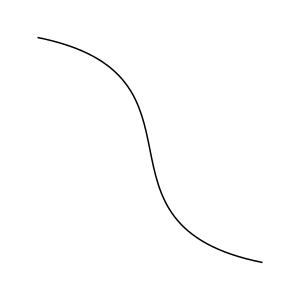

In [6]:
show(paths=[bez.to_svg_path()])

Here's the `Bezier` object, shown along with its control points (indicated with small red circles):

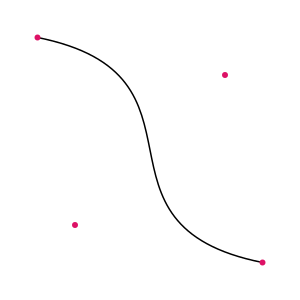

In [7]:
show(paths=[bez.to_svg_path()],
     points=[bez.start, bez.cp1, bez.cp2, bez.end])

You can also create quadratic Bézier curves, using the `QuadraticBezier` class. Quadratic Béziers only have one control point:

In [8]:
qbez = QuadraticBezier(start=[25, 25], cp1=[150, 50], end=[175, 175])

... but just like their cubic cousins, they support the `.to_svg_path()` method:

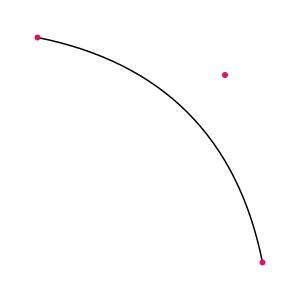

In [9]:
show(paths=[qbez.to_svg_path()],
     points=[qbez.start, qbez.cp1, qbez.end])

### Evaluating points along the curve

Both `Bezier` and `QuadraticBezier` objects have a number of helpful methods for doing calculations with the curves they represent.

The `.point()` method returns the `[x, y]` coordinates of a point at the specified "timestep" on the curve (0 is the beginning of the curve, and 1 is the end of the curve). The following code calculates twelve evenly spaced timesteps on the curve, and puts them in a list:

In [10]:
n_pts = 12
pts = []
for i in range(n_pts + 1):
    pts.append(bez.point(i/n_pts))

In [11]:
pts

[[25.0, 25.0],
 [51.822916666666664, 32.725694444444436],
 [70.83333333333334, 43.05555555555556],
 [83.59375, 55.46875],
 [91.66666666666667, 69.44444444444444],
 [96.6145833333333, 84.46180555555554],
 [100.0, 100.0],
 [103.38541666666667, 115.53819444444447],
 [108.33333333333331, 130.55555555555554],
 [116.40625, 144.53125],
 [129.16666666666669, 156.94444444444446],
 [148.17708333333331, 167.27430555555554],
 [175.0, 175.0]]

Here I'm showing the position of the points we calculated (in red) over the curve itself:

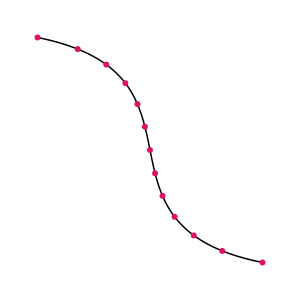

In [12]:
show(paths=[bez.to_svg_path()],
     points=pts)

### Tangents and normals at a timestep

The `.tangent()` function returns the vector (`[x, y]`) that corresponds to the slope of the curve at a particular timestep (again, ranging from 0 at the curve's start to 1 at the curve's end). You can sort of think of this as the "heading" of the curve.

In [14]:
n_tangents = 12
tangents = []
for i in range(n_tangents + 1):
    tangents.append(bez.tangent(i/n_pts))

In [15]:
tangents

[[375.0, 75.0],
 [271.875, 109.37499999999999],
 [187.5, 137.50000000000003],
 [121.875, 159.375],
 [75.0, 175.00000000000003],
 [46.874999999999986, 184.37499999999997],
 [37.5, 187.5],
 [46.875, 184.37500000000003],
 [74.99999999999999, 175.0],
 [121.875, 159.375],
 [187.50000000000003, 137.5],
 [271.87499999999994, 109.37500000000003],
 [375.0, 75.0]]

`Bezier` objects also have a `.tangent_unit()` method, which returns the tangent vector rescaled to unit length:

In [16]:
tangent_u = []
for i in range(n_tangents + 1):
    tangent_u.append(bez.tangent_unit(i/n_pts))
tangent_u

[array([0.98058068, 0.19611614]),
 array([0.92773944, 0.37322851]),
 array([0.806405  , 0.59136366]),
 array([0.60745011, 0.79435783]),
 array([0.3939193 , 0.91914503]),
 array([0.24639878, 0.96916853]),
 array([0.19611614, 0.98058068]),
 array([0.24639878, 0.96916853]),
 array([0.3939193 , 0.91914503]),
 array([0.60745011, 0.79435783]),
 array([0.806405  , 0.59136366]),
 array([0.92773944, 0.37322851]),
 array([0.98058068, 0.19611614])]

Here's a visualization, in which I draw a short line (in blue) that starts at a point along the curve, and ends a little ways along the tangent at that point:

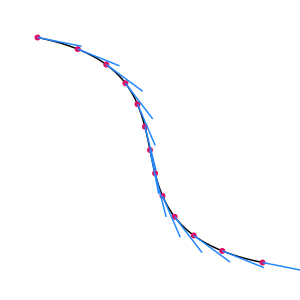

In [17]:
show(paths=[bez.to_svg_path()],
     points=pts,
     lines=[(p[0], p[1], p[0]+t[0]*30, p[1]+t[1]*30) for p, t in zip(pts, tangent_u)])

Likewise, you can get the normal vector (i.e., the vector facing 90 degrees from the tangent) using the `.normal()` method (unscaled), or `.normal_unit()` (scaled to unit length):

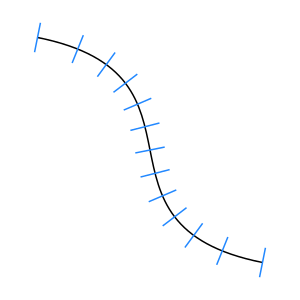

In [18]:
normals = [bez.normal_unit(i/n_pts) for i in range(n_pts+1)]
normal_lines = [(p[0]-u[0]*10, p[1]-u[1]*10, p[0]+u[0]*10, p[1]+u[1]*10)
                for p, u in zip(pts, normals)]
show(paths=[bez.to_svg_path()], lines=normal_lines)

There are a few other useful things that we can do with `Bezier` objects, but before we can talk about them, we need to discuss another class that Bezmerizing supplies: `Polyline`.

## Polylines

A polyline is simply a representation of a sequence of points, usually intended to be connected together to form a chain of line segments that approximate a curve. From a data representation perspective, a polyline is identical to a polygon; the only difference is that in a polyline, you don't connect the last point back to the first point in order to form a closed shape.

Polylines are useful in computer graphics, since you can't actually draw a curve on a traditional pixel-based display. Instead, you need to *approximate* the curve, as accurately as possible, using a sequence of straight lines (i.e., a polyline). Vector-based drawing programs like Inkscape or Illustrator (and the SVG renderer in your browser, and even pen plotters) render curves by breaking them down into polylines in this fashion. The result may appear to be a continuous curve, but in reality, it's not; it's just that the line segments are very short (potentially shorter than the resolution of your display!).

Manipulating polylines computationally is also more efficient and straightforward, than manipulating mathematical representations of curves directly. (Once a curve is represented as a polyline, we don't need any special math to, e.g., apply matrix transformations like rotation and scaling to it.) So often our workflow will look like this: we'll start with `Bezier` objects, and then (at some point) convert them into polylines for further transformation before rendering them to the screen (or the plotter, or whatever).

You can create a `Polyline` object directly by calling the `Polyline` constructor with a list of coordinates (represented as `[x, y]` pairs):

In [19]:
pline = Polyline([[25, 25], [150, 45], [50, 95], [175, 175]])

Internally, Bezmerizing represents polylines as two-dimensional numpy arrays. You can retrieve or set this array directly with the object's `.vertices` attribute:

In [20]:
pline.vertices

array([[ 25,  25],
       [150,  45],
       [ 50,  95],
       [175, 175]])

Like `Bezier` objects, `Polyline` objects have a `.to_svg_path()` method that returns path commands suitable for the `d` attribute of an SVG `path` tag. We can use this method in this notebook to quickly visualize the polyline:

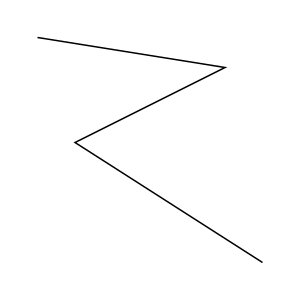

In [21]:
show(paths=[pline.to_svg_path()])

You can get the number of vertices in a `Polyline` object with the `len()` function:

In [22]:
len(pline)

4

And you can get the coordinates of one of the polyline's points by indexing the object as though it were a list:

In [23]:
pline[0]

array([25, 25])

You can concatenate two polylines using the `+` operator (much in the same way that you can use `+` to concatenate two strings):

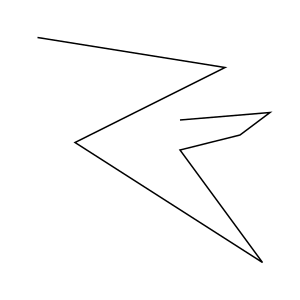

In [24]:
pline2 = Polyline([[120, 100], [160, 90], [180, 75], [120, 80]])
combo = pline + pline2
show(paths=[combo.to_svg_path()])

### Transformations

Every `Polyline` object has `.translate()`, `.rotate()` and `.scalexy()` methods, which return a copy of that polyline with the corresponding transformation applied. The `.scalexy()` method takes two parameters: the scale factor to apply to the X coordinates, and the scale factor to apply to the Y coordinates. For example:

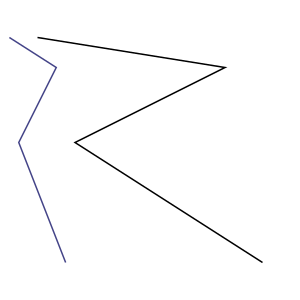

In [25]:
# note that when show() is called with more than one path, paths
# after the first are shown in a lighter shade of grey
squashed = pline.scalexy(0.25, 1)
show(paths=[pline.to_svg_path(), squashed.to_svg_path()])

The `.translate()` method also takes two parameters: the distance to translate the figure on the X axis, and the distance to translate the figure on the Y axis:

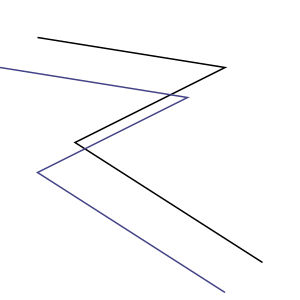

In [26]:
shifted = pline.translate(-25, 20)
show(paths=[pline.to_svg_path(), shifted.to_svg_path()])

The `.rotate()` method takes the angle by which to rotate the points in the polyline (specified in radians). Note that this rotates around the coordinate (0, 0), which is in the upper left-hand corner:

Polyline([[30.4079, 18.0377], [156.4700, 6.4905], [71.9490, 79.6765], [212.8554, 126.2640]])


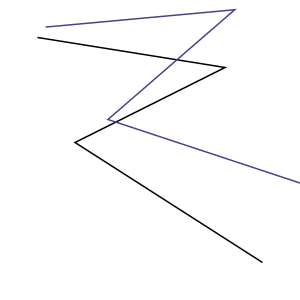

In [27]:
rotated = pline.rotate(0.25)
print(rotated)
show(paths=[pline.to_svg_path(), rotated.to_svg_path()])

If you want to make the polyline rotate around its center, the easiest way is to specify the polyline's coordinates as though it was already drawing its center at (0, 0), then rotate it and translate it to the actual desired position. In the following example, I've defined a new polyline with the same shape as the example above, and then shown a rotated and translated version of that polyline along with the original.

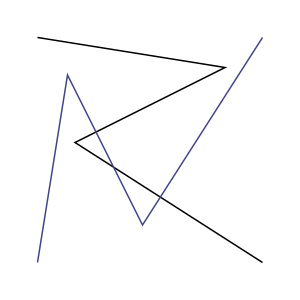

In [28]:
pline_zero = Polyline([[-75, -75], [50, -55], [-50, -5], [75, 75]])
rotated_zero = pline_zero.rotate(np.pi*0.5) # one quarter turn
translated_zero = rotated_zero.translate(100, 100)
show(paths=[pline.to_svg_path(), translated_zero.to_svg_path()])

For other kinds of transformations, you can operate on the `.vertices` array directly:

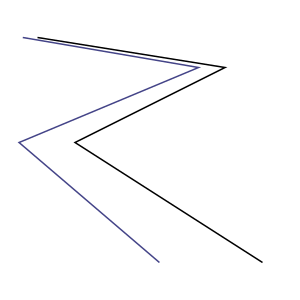

In [29]:
# apply a shear transformation directly with numpy
sheared = Polyline(
    pline.vertices.dot(np.array([[1, 0], [-np.pi/8, 1]])))
show(paths=[pline.to_svg_path(), sheared.to_svg_path()])

### Resampling

The `.resample()` method of a `Polyline` object returns a new polyline with each constituent line replaced with a *series* of line segments along that line. The `samples_per` parameter controls the number of line segments per line. Below, I've resampled the example polyline above with ten segments per line, and also drawn the endpoints of each segment:

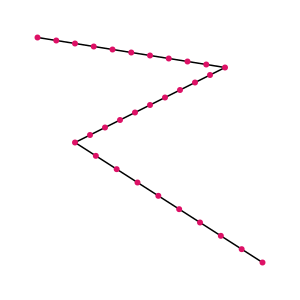

In [30]:
resampled = pline.resample(10)
show(paths=[resampled.to_svg_path()], points=resampled.vertices)

Resampling is useful if you want to apply a transformation point-by-point along the polyline, and have variation between the original line segment boundaries. For example, in the code below I apply some trigonometry to make the polyline a little wavy (shown here with the original polyline, so you can see the difference easily):

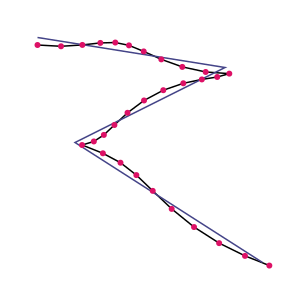

In [31]:
wavy = Polyline(
    resampled.vertices + np.stack(
        [np.sin(np.linspace(0, 20, len(resampled)))*5,
        np.cos(np.linspace(0, 20, len(resampled)))*5]).T
)
show(paths=[wavy.to_svg_path(), pline.to_svg_path()], points=wavy.vertices)

## Bézier curves to polylines

Bezmerizing has a few ways to convert Bézier curves to polylines. Let's discuss!

### Sample the curve

The first is the Bézier object's `.to_polyline()` method, which samples points along the Bézier curve, using the specified number of samples. (Under the hood, this uses the same `.point()` method of `Bezier` objects that we discussed above.) I'm using that method below and displaying the resulting polyline, along with the points of that polyline:

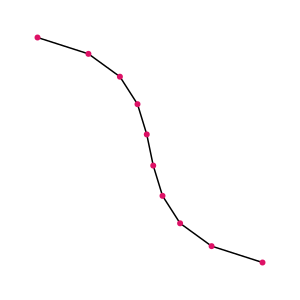

In [32]:
bez_pline = bez.to_polyline(10)
show(paths=[bez_pline.to_svg_path()], points=bez_pline.vertices)

Now we can apply transformations to the resulting polyline, e.g.:

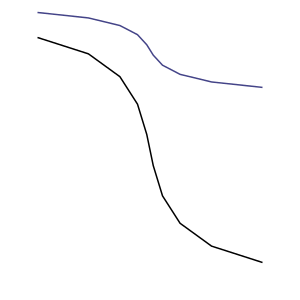

In [33]:
bez_pline_squished = bez_pline.scalexy(1, 0.333)
show(paths=[bez_pline.to_svg_path(), bez_pline_squished.to_svg_path()])

Note that with a low number of samples, the results of converting a Bézier to a polyline have visible artifacts: you can see the individual line segments. But as the number of samples goes up, the fidelity of the approximation improves, to the point that these artifacts are no longer apparent:

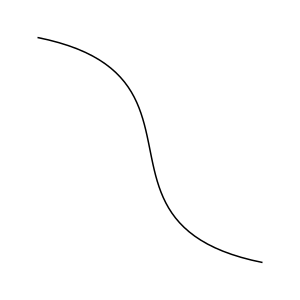

In [34]:
bez_pline_hires = bez.to_polyline(50)
show(paths=[bez_pline_hires.to_svg_path()])

### Curve offsets

The `.offsets()` method returns a polyline with points at specified distances along the curve normal. The *normal* of a curve is the direction at a right angle to the tangent of the curve at a particular point, facing away from the curve, so the `.offsets()` method gives us a way to create a Polyline that sort of runs in "parallel" to the original curve. The length of the `distances` parameter determines the number of samples that will be taken along the curve, and the value at each index determines the distance along the normal that will be calculated for the sample at that index.

> **Note**: The number of points in the curve may not always exactly match the length of the `distances` parameter; see "Tuning offsets" below.

Here's an example. Remember that we can make a repeating array of numbers in Python with the `*` operator, when there is a list on the left and an integer on the right:

In [35]:
[-10] * 12

[-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]

Passing a list like this to `.offsets()` gives us a polyline offset from the original line, with twelve samples, each of which is `-10` units of distance from the original curve:

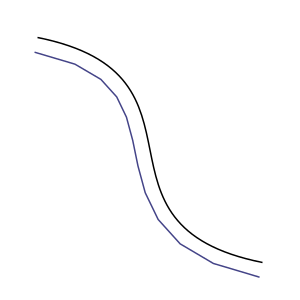

In [36]:
offset_pline = bez.offsets([-10]*12)
show(paths=[bez.to_svg_path(), offset_pline.to_svg_path()])

The `np.linspace()` function in numpy is an easy way to create a list of numbers with a specific length, that interpolates from a value at the beginning until it reaches the end. For example, the following expression evaluates to an array that smoothly interpolates from 3 to 25 in ten steps:

In [37]:
np.linspace(3, 25, 10)

array([ 3.        ,  5.44444444,  7.88888889, 10.33333333, 12.77777778,
       15.22222222, 17.66666667, 20.11111111, 22.55555556, 25.        ])

Using `np.linspace()` plus `.offsets()` gives us a quick way to draw polylines that follow the original Bézier curve, but gradually move away or towards it:

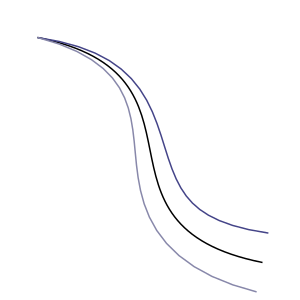

In [38]:
diverging_pline1 = bez.offsets(np.linspace(0, 20, 25))
diverging_pline2 = bez.offsets(np.linspace(0, -20, 25))
show(paths=[bez.to_svg_path(),
            diverging_pline1.to_svg_path(),
            diverging_pline2.to_svg_path()])

Or we can use `np.linspace()` as a parameter to another function to produce other effects. Recall that numpy functions usually take numpy arrays as parameters, and apply the function across every element of the given array, returning the result as a new array:

In [39]:
# calculate the cosine of values from zero to pi*2, at twelve equally-placed steps
np.cos(
    np.linspace(0, np.pi*2, 12)
)

array([ 1.        ,  0.84125353,  0.41541501, -0.14231484, -0.65486073,
       -0.95949297, -0.95949297, -0.65486073, -0.14231484,  0.41541501,
        0.84125353,  1.        ])

So let's make the curve wobbly with the `np.sin()` function:

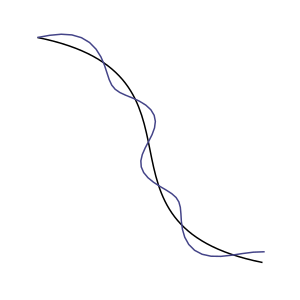

In [40]:
wavy_offsets_pline = bez.offsets(np.sin(np.linspace(0, 20, 50))*8)
show(paths=[bez.to_svg_path(), wavy_offsets_pline.to_svg_path()])

Of course, you can construct the list of offsets however you'd like. Here's an example that adds one of two offsets at each point in the list at random, producing a kind of harsh squiggly effect:

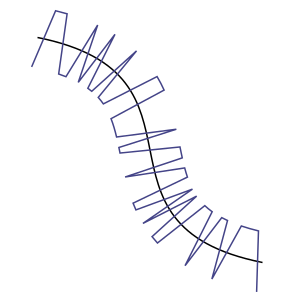

In [41]:
import random
my_offsets = []
for i in range(50):
    if random.random() < 0.5:
        my_offsets.append(20)
    else:
        my_offsets.append(-20)
pulse_pline = bez.offsets(my_offsets)
show(paths=[bez.to_svg_path(), pulse_pline.to_svg_path()])

The `.offset_polygon()` method returns a polyline with the given offsets on *both sides* of the curve:

In [42]:
poly = bez.offset_polygon(np.linspace(4, 24, 20))

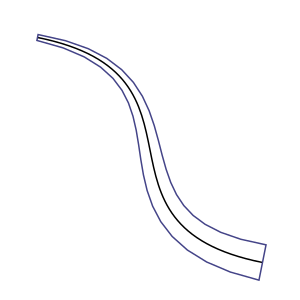

In [43]:
show(paths=[bez.to_svg_path(), poly.to_svg_path(close=True)])

You can use this to create filled shapes that follow the original curve's path. The `close=True` parameter to the `.to_svg_path()` method ensures that the path is closed (by appending the `Z` path element). (See this [notebook on imitating line thickness variations](https://github.com/aparrish/material-of-language/blob/master/imitating-line-thickness-variation.ipynb) for some examples.)

### Tuning offsets

Generating mathematically robust and aesthetically pleasing offset curves is [an open problem in computer graphics](https://scholar.google.com/scholar?hl=en&q=bezier+curve+offset). Bezmerizing's `.offsets()` methods (and other methods that rely on it, like `.fancy_curve()` below) have a few behaviors intended to "clean up" a handful of common artifacts that happen when offsetting Bézier curves. By default, for this reason, *the offset curve may not have the same number of points as the length of the list of distances that you pass to it*, nor will the points in the offset curve reliably correspond index-wise to evenly-spaced points along the curve. You can disable these behaviors by passing `trim=False` and `subdivide=False` to the `.offsets()` method.

Let's take a look at some of the artifacts that the `.offsets()` method attempts to work around. First of all, curves that are sufficiently tight may produce offset curves with "cusps," which result from the direction of the normal doubling back on itself. For example, here's a tight curve and an offset polyline from that curve, with the `.offsets()` method's cleanup behaviors disabled:

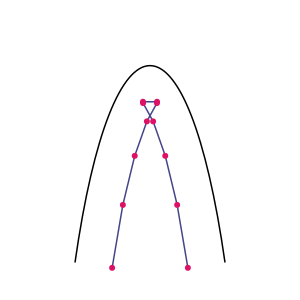

In [44]:
cuspy = Bezier(start=[50, 175], cp1=[75, 0], cp2=[125, 0], end=[150, 175])
cuspy_offset_bad = cuspy.offsets([-25]*12, trim=False)
show(paths=[cuspy.to_svg_path(), cuspy_offset_bad.to_svg_path()],
     points=cuspy_offset_bad.vertices)

You can see the "doubling back" of the offset curve. By default, the `.offsets()` method attempts to detect and remove these cusps, using a technique inspired by Elber and Cohen (1991):

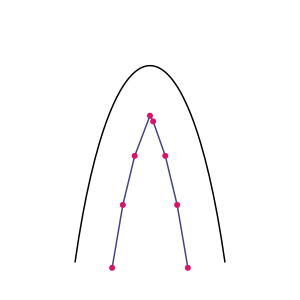

In [45]:
cuspy = Bezier(start=[50, 175], cp1=[75, 0], cp2=[125, 0], end=[150, 175])
cuspy_offset_good = cuspy.offsets([-25]*12)
show(paths=[cuspy.to_svg_path(), cuspy_offset_good.to_svg_path()],
     points=cuspy_offset_good.vertices)

Another problem that arises when calculating offsets from curves is undersampling, i.e., the samples are sparse enough that the polyline will "jump over" important parts of the curve. For example, here's another fairly tight Bézier, drawn with an undersampled offset curve on its outside:

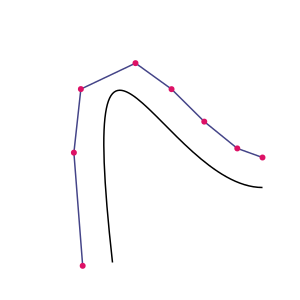

In [46]:
crunchy = Bezier(start=[75, 175], cp1=[50, -50], cp2=[110, 125], end=[175, 125])
crunchy_offset_bad = crunchy.offsets([20]*8, subdivide=False)
show(paths=[crunchy.to_svg_path(), crunchy_offset_bad.to_svg_path()],
     points=crunchy_offset_bad.vertices)

You can see that the offset curve is flat at the curve's apex, which misrepresents the shape of the curve. Bezmerizing's `.offsets()` function uses recursive subdivision to solve this problem. If the slice of the curve corresponding to an offset segment falls does not meet a threshold of flatness, then that segment is split in two, and the offsets are recalculated for both halves.

> **Technical note**: What does "flatness" mean in Bezmerizing? I've defined the "base length" of a curve as the length of the line segment connecting points $P_0$ and $P_n$ in a curve (i.e., its start and end points). "Flatness" is the ratio of the absolute value of the maximum distance from any of $P_1$ to $P_{n-1}$ (i.e., the control points) to base length. A flatness of zero means that the curve is totally flat (i.e., the control points are on the base segment). This is all kinda arbitrary but it works for me!

Here's an example with the subdivision behavior enabled (this is the default):

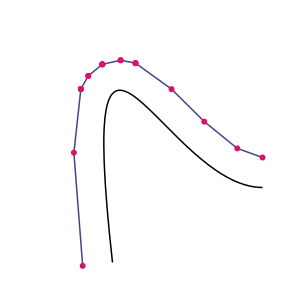

In [47]:
crunchy = Bezier(start=[75, 175], cp1=[50, -50], cp2=[110, 125], end=[175, 125])
crunchy_offset_good = crunchy.offsets([20]*8)
show(paths=[crunchy.to_svg_path(), crunchy_offset_good.to_svg_path()],
     points=crunchy_offset_good.vertices)

You can see that the `.offsets()` method automatically detected the "flat" offset segment, and resampled it to better represent the underlying curve. You can also change the flatness "threshold" to your taste! The default is `0.1`; lower values will resample more aggressively, higher values will be more conservative. Example:

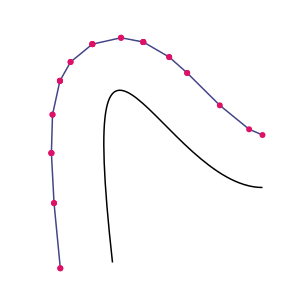

In [48]:
crunchy = Bezier(start=[75, 175], cp1=[50, -50], cp2=[110, 125], end=[175, 125])
crunchy_offset_good = crunchy.offsets([35]*8, threshold=0.01)
show(paths=[crunchy.to_svg_path(), crunchy_offset_good.to_svg_path()],
     points=crunchy_offset_good.vertices)

## Polyline to Bézier splines with Catmull-Rom

It's often useful to be able to use a polyline as a "skeleton" and then draw a curve that follows the skeleton. Broadly this process is called "interpolation" and there are [a bunch of ways to do it](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html). A common algorithm for interpolating polylines in a 2D drawing context is the [Catmull-Rom spline](https://en.wikipedia.org/wiki/Cubic_Hermite_spline#Catmull%E2%80%93Rom_spline) (Catmull and Rom 1974), which is relatively easy to compute and always goes through every point in the polyline. (Catmull-Rom is also [the algorithm that, e.g., p5js uses](https://p5js.org/reference/p5/curve/) to produce smooth curves through points.)

Given a series of points, Catmull-Rom produces a *sequence of connected Bézier curves*. There's a special word for a sequence of connected curves: "spline." Accordingly, Bezmerizing represents the result of Catmull-Rom with a special `Spline` class. The methods of `Spline` objects are very similar to the methods of `Bezier` objects: you can a `Spline` to `Polyline` (`.to_polyline()`), get a string with an SVG path to draw the spline (`.to_svg_path()`), get a new polyline composed of tangent offsets (`.offsets()`) and get a symmetrical polygon from tangent offsets (`.offset_polygon()`).

You can get the Catmull-Rom spline of a `Polyline` object by calling its `.catmull_spline()` method. Let's take a look at an example. First, I'm going to make a `Polyline` object with a series of random points:

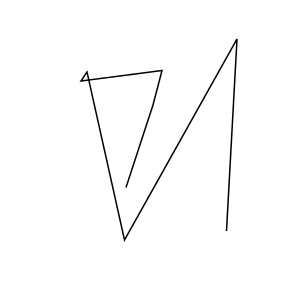

In [82]:
import random
pts = []
for i in range(8):
    pts.append([random.randrange(20, 180), random.randrange(20, 180)])
rand_pline = Polyline(pts)
show(paths=[rand_pline.to_svg_path()])

And then I'll call the `Polyline` object's `.catmull_spline()` method:

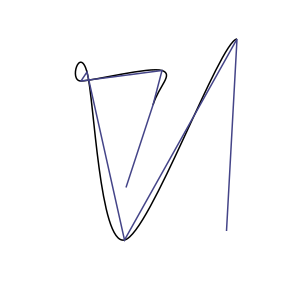

In [83]:
spline = rand_pline.catmull_spline()
show(paths=[spline.to_svg_path(), rand_pline.to_svg_path()])

You should see the original polyline (with sharp angles), with a smooth curve running around it. That curve is made of the multiple `Bezier` objects of the spline, which you can examine by accessing the `Spline` object's `.beziers` attribute:

In [84]:
spline.beziers

[Bezier(start=[102.0000, 70.0000], cp1=[106.0000, 57.0000], cp2=[116.0000, 49.6667], end=[108.0000, 47.0000]),
 Bezier(start=[108.0000, 47.0000], cp1=[100.0000, 44.3333], cp2=[62.3333, 53.8333], end=[54.0000, 54.0000]),
 Bezier(start=[54.0000, 54.0000], cp1=[45.6667, 54.1667], cp2=[53.1667, 30.3333], end=[58.0000, 48.0000]),
 Bezier(start=[58.0000, 48.0000], cp1=[62.8333, 65.6667], cp2=[66.3333, 163.6667], end=[83.0000, 160.0000]),
 Bezier(start=[83.0000, 160.0000], cp1=[99.6667, 156.3333], cp2=[146.6667, 27.0000], end=[158.0000, 26.0000])]

### Tightness

The `.catmull_spline()` method has one parameter, `tightness`, that allows you to control the character of the curve. The default value is `0.0`; at `1.0` the Catmull-Rom algorithm returns straight lines, and you can adjust the parameter between these values to get more or less dramatic curves. The code in the cell below selects a random number from -3 to 3 and uses it as the tightness parameter. Run it multiple times to see how the parameter affects the curve.

-2.690


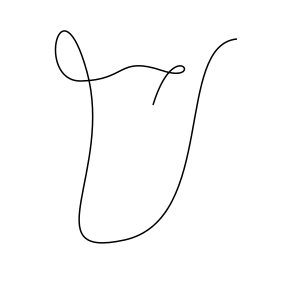

In [90]:
import random
tightness_val = random.uniform(-3, 3)
print(f"{tightness_val:0.3f}")
spline = rand_pline.catmull_spline()
show(paths=[rand_pline.catmull_spline(tightness_val).to_svg_path()])

### Extra points

The observant among you will notice that the curves above seem to be missing the beginning and ending points of the polyline. This results from the fact that the Catmull-Rom algorithm uses the first and last points of the polyline as part of the shape of the first curve in the spline. The best way to get around this is to make sure that your procedure for producing lists of points keeps this fact about the Catmull-Rom algorithm in mind. In a pinch, you can also use the `Polyline` object's `.augment()` method to get a copy of the polyline with its first and last points repeated:

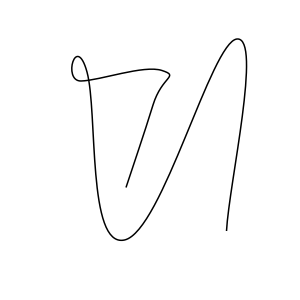

In [91]:
augmented = rand_pline.augment()
spline = augmented.catmull_spline(-0.5)
show(paths=[spline.to_svg_path()])

### Splines to polylines

Just like `Bezier` objects, `Spline` objects have a `.to_polyline()` method that samples the spline along its length and returns a `Polyline` object. Let's take a look:

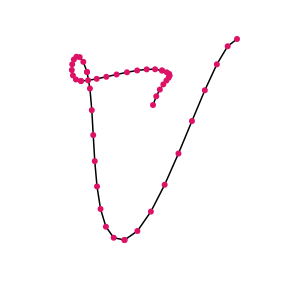

In [92]:
spline = rand_pline.catmull_spline(-0.5)
spline_pline = spline.to_polyline(10)
show(paths=[spline_pline.to_svg_path()], points=spline_pline.vertices)

The single paramter to the `Spline` object's `.to_polyline()` method specifies the number of samples to include *for each curve in the spline* (meaning that `len(spline.to_polyline(n)) == len(spline.beziers)*n` should evaluate to true).

Likewise, `Spline` objects have `.offsets()` and `.offset_polygon()` methods that operate in a fashion similar to their `Bezier` analogues. The first parameter of these methods is an array of offset distances to apply across the length of the spline. The second parameter (`samples_per`) specifies the number of samples to include *for each curve in the spline*. If the list of offset distances doesn't match the number of needed points to sample the entire curve (i.e., the number of splines times the number of samples per curve), then Bezmerizing will resample the list of distances to the needed length using [cubic interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline).

Here's a single offset of our random curve:

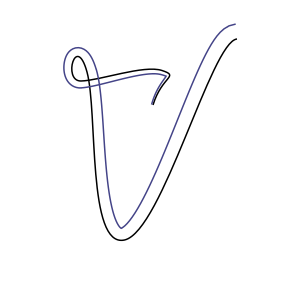

In [93]:
spline = rand_pline.catmull_spline(-0.5)
spline_offset = spline.offsets(np.linspace(1, 10, 3), samples_per=40)
show(paths=[spline.to_svg_path(), spline_offset.to_svg_path()])

And an "offset polygon":

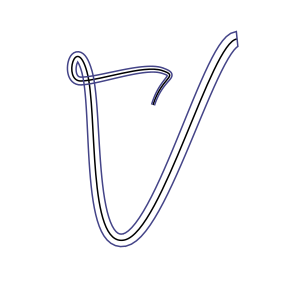

In [94]:
spline = rand_pline.catmull_spline(-0.5)
spline_offset_polygon = spline.offset_polygon(np.linspace(2, 10, 3), samples_per=30)
show(paths=[spline.to_svg_path(), spline_offset_polygon.to_svg_path()])

### Fancy curves: Putting everything together

The `.fancy_curve()` method of a `Polyline` object returns a `Polyline` that results from converting the `Polyline` object to a spline (with Catmull-Rom), then calling `.offset_polygon()` on the resulting spline. This makes it easy to go from a polyline to an expressive "stroke," as seen in the example below. (Note that the `path_fill` parameter of my `show()` function causes each SVG path to be drawn with a solid fill.)

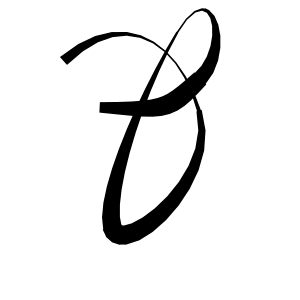

In [95]:
# create a random list of points
pts = [[np.random.uniform(20, 180), np.random.uniform(20, 180)] for i in range(8)]
# create a list of values resulting from the sin function on an increasing list of numbers
thicknesses = (np.sin(np.linspace(0, np.pi*4, 100))+1) * 6 # scale by 6
# create the curve
poly = Polyline(pts).fancy_curve(thicknesses=thicknesses, samples_per=12, tightness=-1.5)
show(paths=[poly.to_svg_path(close=True)], path_fill=True)

# Polyline lists

It's common for a single shape to consist of multiple component shapes that can't easily be represented as a single polyline. For example, the `:` character has two shapes: the dot on the bottom, and the dot on the top. You can think of the letter `O` has having two shapes: the outline of the outer circle, and the outline of the inner circle (i.e., the hole in the middle). To represent shapes like this, Bezmerizing provides the `PolylineList` class. Let's take a shape like the one below, which I'm first going to represent as two separate polylines:

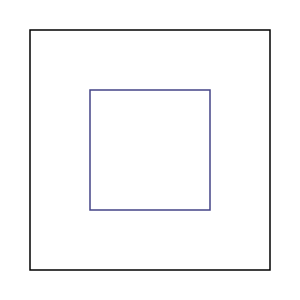

In [96]:
outer = Polyline([[20, 20], [180, 20], [180, 180], [20, 180]])
inner = Polyline([[60, 60], [140, 60], [140, 140], [60, 140]])
show(paths=[outer.to_svg_path(close=True), inner.to_svg_path(close=True)])

You can make a `PolylineList` with these two shapes like so:

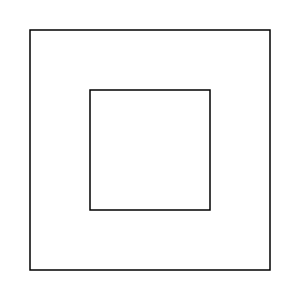

In [97]:
square_thing = PolylineList([outer, inner])
show(paths=[square_thing.to_svg_path(close=True)])

Any transformations you apply to the `PolylineList` will be applied to all polylines in the list:

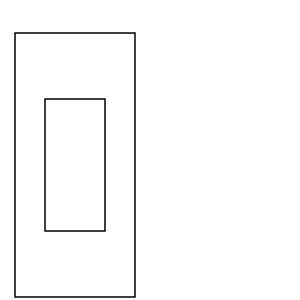

In [98]:
show(paths=[square_thing.scalexy(0.5, 1.1).to_svg_path(close=True)])

One use of `PolylineList`s is rendering shapes with cutouts (like the letter `O`). Depending on the renderer you're using, a polyline inside of another polyline in the same list will be shown as a cutout shape. By default, [SVG uses the "nonzero winding rule."](https://www.w3.org/TR/SVG2/painting.html#WindingRule) Under this rule, if we draw the shape we've just made with fill enabled, both the outer square and the inner square will be filled:

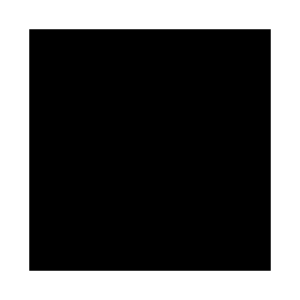

In [99]:
show(paths=[square_thing.to_svg_path(close=True)], path_fill=True)

This is because the nonzero winding rule dictates that cutout shapes must have their points in *counterclockwise* order. The points in our inner shape are clockwise (draw the points out, on paper, in order to help visualize this, if you need to). The `.is_clockwise()` method of a `Polyline` object returns `True` if the polyline is clockwise, and false otherwise:

In [100]:
inner.is_clockwise()

True

You can change a clockwise polyline to a counterclockwise polyline using the `.reverse()` method:

In [101]:
ccw_inner = inner.reverse()
ccw_inner.is_clockwise()

False

Now check out what happens when we draw a `PolylineList` with these two components:

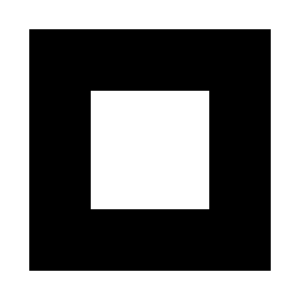

In [102]:
hollow_square_thing = PolylineList([outer, ccw_inner])
show(paths=[hollow_square_thing.to_svg_path(close=True)], path_fill=True)

# Polyline primitives

Bezmerizing has several functions for creating `Polyline` objects from geometrical primitives:

In [103]:
from bezmerizing.primitives import arc, ellipse, circle, rect

In [104]:
# center x, center y, x radius, y radius, start angle, end angle
a = arc(100, 100, 40, 60, 0, (3/2)*np.pi)
b = ellipse(75, 75, 60, 40)
c = circle(75, 75, 50)
d = rect(40, 25, 80, 50) # top left x, top left y, width, height

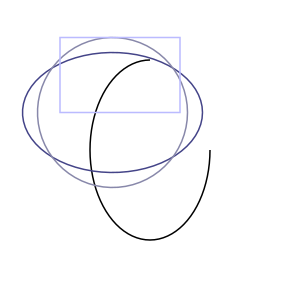

In [105]:
show(paths=[a.to_svg_path(), b.to_svg_path(), c.to_svg_path(), d.to_svg_path(close=True)])

By default, the arc-related functions (`arc()`, `circle()`, `ellipse()`) include 64 segments in the polyline; you can increase or decrease this as needed with the `n` parameter:

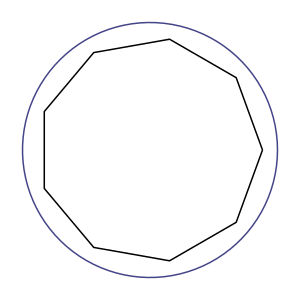

In [106]:
jaggy = circle(100, 100, 75, n=10)
smooth = circle(100, 100, 85, n=100)
show(paths=[jaggy.to_svg_path(), smooth.to_svg_path()])

The `rect()` function does not include the final point in the shape, while the `circle()`, `ellipse()` and `arc()` functions do. If you want to make a regular polygon with $n$ sides, pass $n + 1$ to the function. A hexagon, for example:

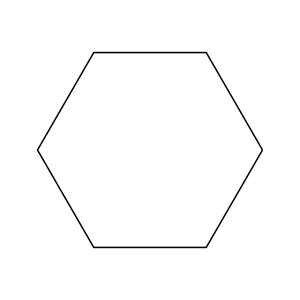

In [107]:
b = circle(100, 100, 75, n=7)
show(paths=[b.to_svg_path()])

You can call the `.fancy_curve()` method on polylines constructed with this method:

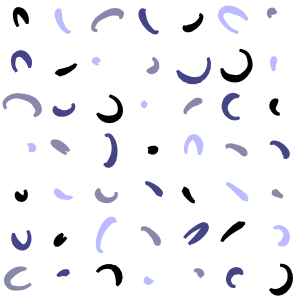

In [108]:
paths = []
grid_size = 7
grid_res = 200 / grid_size
for i in range(grid_size):
    for j in range(grid_size):
        poly = ellipse(0, 0,
                       np.random.uniform((200/grid_size)*0.4),
                       np.random.uniform((200/grid_size)*0.4),
                       n=np.random.choice([4, 5, 6, 7]))
        poly_fancy = poly.fancy_curve(thicknesses=[1, 2, 3, 4, 1],
                                      tightness=-0.5).rotate(np.random.uniform(np.pi*2))
        poly_transform = (poly_fancy
                          .rotate(np.random.uniform(np.pi*2))
                          .translate((0.5*grid_res) + grid_res*i, (0.5*grid_res) + grid_res*j))
        paths.append(poly_transform.to_svg_path())
show(paths=paths, path_fill=True)

An example with `arc` primitives and `.fancy_curve()`:

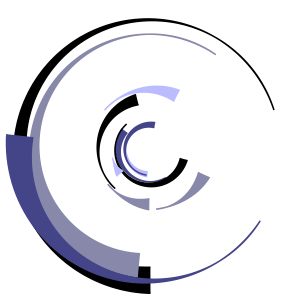

In [109]:
parts = []
for i in range(12):
    arc_poly = arc(0, 0, 50, 50, np.random.uniform(0, np.pi*2), np.random.uniform(0, np.pi*2))
    poly = arc_poly.fancy_curve(thicknesses=[10, 5, 1, 0])
    poly = poly.scale(np.random.uniform(0.1, 1.75)).translate(100, 100)
    parts.append(poly.to_svg_path())
show(paths=parts, path_fill=True)

# References

Elber, Gershon, and Elaine Cohen. “Error Bounded Variable Distance Offset Operator for Free Form Curves and Surfaces.” *International Journal of Computational Geometry & Applications*, vol. 01, no. 01, Mar. 1991, pp. 67–78. https://doi.org/10.1142/S0218195991000062.

Catmull, Edwin, and Raphael Rom. “A Class of Local Interpolating Splines.” Computer Aided Geometric Design, edited by Robert E. Barnhill and Richard F. Riesenfeld, Academic Press, 1974, pp. 317–26. https://doi.org/10.1016/B978-0-12-079050-0.50020-5.